# Notes

This script replicates the Fama French 5 (2x3) risk factors SMB, HML, RMW, and CMA, in addition to the excess market risk factor, and augments the factor set with a candidate factor based on measures pass by the user in a file or a a list of files. The data come from CRSP for pricing related items and Compustat for fundamental data. The data are accessed through WRDS.

This script has been adapted from the Fama French 3 factors script posted on WRDS, written by Qingyi (Freda) Song Drechsler in April 2018 and updated in June 2020.<br>(https://wrds-www.wharton.upenn.edu/pages/support/applications/python-replications/fama-french-factors-python/<br>https://www.fredasongdrechsler.com/full-python-code/fama-french)"

Research notes:

- only ordinary common stocks (CRSP sharecode 10 and 11) in NYSE, AMEX and NASDAQ (exchange code 1,2,3) and at least 2 years on Compustat are included in the sample (Fama and French (1993, 2015); https://wrds-www.wharton.upenn.edu/pages/support/applications/risk-factors-and-industry-benchmarks/fama-french-factors/).
- all the breakpoints are computed only on NYSE stocks (from the sample).
- market cap is calculated at issue-level (permno in CRSP), and book value of equity is calculated at company level (permco in Compustat), it is needed to aggregate market cap at company level (permco in CRSP) for later book-to-market value calculation. And market cap of companies at December of year t-1 is used for portfolio formation at June of year t. Details on how to link CRSP and Compustat:<br>
    https://wrds-www.wharton.upenn.edu/pages/support/manuals-and-overviews/crsp/crspcompustat-merged-ccm/wrds-overview-crspcompustat-merged-ccm/<br>https://wrds-www.wharton.upenn.edu/pages/support/applications/linking-databases/linking-crsp-and-compustat/
- there were cases when the same firm (CRSP permco) had two or more securities (CRSP permno) on the same date. For the purpose of ME for the firm, I aggregated all ME for a given CRSP permco, date. This aggregated ME was assigned to the CRSP permno according to the following criteria largest market equity (ME), higher number of years on Compustat (count) (as recommended by WRDS (https://wrds-www.wharton.upenn.edu/pages/support/applications/risk-factors-and-industry-benchmarks/fama-french-factors/) and finally random, in this order. If the ME and years on Compustat are the same there is no other unbiased criteria but random (one would select the one with either largest or smallest return). However these cases are less than 100. The ME to assign to the permco is the sum of the ME of all the permno of that permco.
- the relevant share code for Fama French factors constructions are 10 and 11 (ordinary common stocks). The permno for the same permco may have different share code (shrcd), filtering them before applying the logic o the previous point would end up in loosing market capitalization. The solution is to delete later, when each permco has only one permno, all the permno with shrcd different from 10 or 11.
- I merged CRSP and Compustat using the CRSP CCM product (as of April 2010) as recommended by WRDS (https://wrds-www.wharton.upenn.edu/pages/support/applications/risk-factors-and-industry-benchmarks/fama-french-factors/) matching Compustat's gvkey (from calendar year t-1) to CRSP's permno as of June year t. Data was cleaned for unnecessary duplicates. First there were cases when different gvkeys exist for same permno-date. I solved these duplicates by only keeping those cases that are flagged as 'primary' matches by CRSP's CCM (linkprim='P'). There were other unnecessary duplicates that were removed (I kept the oldest gvkey for each permno, finally I randomly picked one gvkey for each of of the about 30 pairs od dupliated permno which were practically identical if not for fractions of decimals differences on certain measures). Some companies on Compustat may have two annual accounting records in the same calendar year. This is produced by change in the fiscal year end during the same calendar year. In these cases, we selected the last annual record for a given calendar year.

Variable definitions (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/variable_definitions.html)

- ME: Market Equity. Market equity (size) is price times shares outstanding. Price is from CRSP, shares outstanding are from Compustat (if available) or CRSP.

- BE: Equity. Book equity is constructed from Compustat data or collected from the Moody’s Industrial, Financial, and Utilities manuals. BE is the book value of stockholders’ equity, plus balance sheet deferred taxes and investment tax credit (if available), minus the book value of preferred stock. Depending on availability, we use the redemption, liquidation, or par value (in that order) to estimate the book value of preferred stock. Stockholders’ equity is the value reported by Moody’s or Compustat, if it is available. If not, we measure stockholders’ equity as the book value of common equity plus the par value of preferred stock, or the book value of assets minus total liabilities (in that order). See Davis, Fama, and French, 2000, “Characteristics, Covariances, and Average Returns: 1929-1997,” Journal of Finance, for more details.

- BE/ME: Book-to-Market. The book-to-market ratio used to form portfolios in June of year t is book equity for the fiscal year ending in calendar year t-1, divided by market equity at the end of December of t-1.
 
- OP: Operating Profitability. The operating profitability ratio used to form portfolios in June of year t is annual revenues minus cost of goods sold, interest expense, and selling, general, and administrative expense divided by the sum of book equity and minority interest for the last fiscal year ending in t-1.
 
- INV: Investment. The investment ratio used to form portfolios in June of year t is the change in total assets from the fiscal year ending in year t-2 to the fiscal year ending in t-1, divided by t-2 total assets.

Techincal notes:

- In order to tun the script one has to connect ot the WRDS databases and have a valid WRDS account. Here are the details on how to set up a connection or run the scrip on the WRDS cloud.<br>https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/python-wrds-cloud/<br>https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/python-from-your-computer/
- WRDS Python library documentation
https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/querying-wrds-data-python/

User guide:

- Basic
    - the user has to place one or more measures file (.csv) in the path assigned to the variable nf_measures_path
    - each measure file can contain multiple measures on the columns (with headers)
    - each measure file contains on the rows pairs of "jdate" (dates of last day of June in format YYYY-MM-DD) and "permno" (containing Compustat PERMNO). The first two columns in the csv file must be called "permno and "date"
    - for each measure file passed, the corresponding factors (and additional file for firms count) are saved in a csv file with a similar name, the rows are oranized for date, measure for which robust breakpoints have been choosed, the breakpoints percentailes, measure name

- Advanced
    - in the Fama French 5 factors procedure the factors are constructed using as breakpoints 30th and 70th percentiles for B/M, OP, and INV
    - here the user can specify in the list variable measures_robust_check_bp all the factors for which he or she wants to use alternative breakpoint percentiles (for instance measures_robust_check_bp=['bm', 'inv', 'op', 'nf'] if alternative breakpoints want ot be used for all the factors)
    - the alernative breakpoints are fixed to be 10th and 90th, 20th and 80th, 30th and 70th, 40th and 60th.

Descriptions of Fama French 5 factors (2x3) can be found on Kenneth French's website.<br>http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html <br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html"

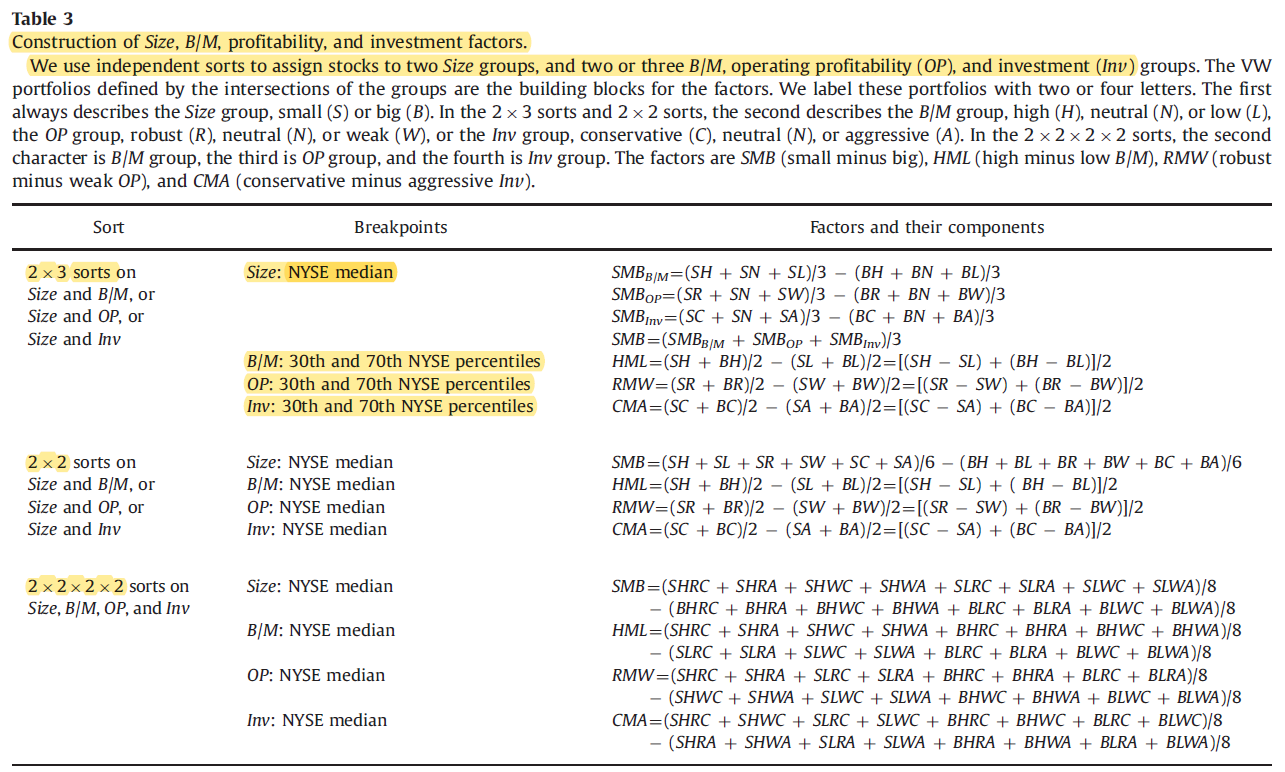

References:
- Fama, Eugene F. and Kenneth R. French, 1993, Common Risk Factors in Stocks and Bonds, Journal of Financial Economics, 33, 3-56.
- Fama, E.F. and French, K.R., 2015. A five-factor asset pricing model. Journal of financial economics, 116(1), pp.1-22.

# Script

In [1]:
# list of all measures for which a factor will be computed
all_measures=['bm','inv','op','nf']
# measures for which all the breakpoints (10_90, 20_80, 30_70, 40_60) subsets are used instead of the default 30_70
# measures_robust_check_bp=['bm', 'inv', 'op', 'nf']
measures_robust_check_bp=['nf']

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt
import urllib
import zipfile
from scipy import stats
import glob
from tqdm import tqdm
import warnings
import os

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

#set to 1 to delete intermediate datasets
save_memory=0

#set to 1 to print more check outputs
print_advance_output=0

## Functions

In [3]:
# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

## Computation

In [4]:
project_path="G:\\My Drive\\PhD\\Research\\Indipendent project\\"
factors_path="G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\factors\\"
test_assets_path="G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\test_assets\\"
ff5measures_path="G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\FF5 measures\\"
nf_measures_path="G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\"

Read the CRSP table with stock returns produced by FF5_measures_computer_and_FF5_factors_replicator\FF5_measures_computer_and_FF5_factors_replicator.ipynb

In [5]:
crsp3=pd.read_csv(ff5measures_path+'crsp_returns.csv', sep=',')
crsp3['jdate']=pd.to_datetime(crsp3['jdate'])
# crsp3.set_index(['permno','jdate'], inplace=True)
crsp3

permno        date      jdate  ffyear    retadj            wt
0         10000  1986-07-31 1986-07-31    1986 -0.080808  1.173459e+04
1         10000  1986-08-29 1986-08-31    1986 -0.615385  1.078634e+04
2         10000  1986-09-30 1986-09-30    1986 -0.057143  4.148594e+03
3         10000  1986-10-31 1986-10-31    1986 -0.242424  3.911531e+03
4         10000  1986-11-28 1986-11-30    1986  0.060000  2.963281e+03
...         ...         ...        ...     ...       ...           ...
3068885   93436  2020-08-31 2020-08-31    2020  0.741452  2.661214e+08
3068886   93436  2020-09-30 2020-09-30    2020 -0.139087  4.634376e+08
3068887   93436  2020-10-30 2020-10-31    2020 -0.095499  3.989793e+08
3068888   93436  2020-11-30 2020-11-30    2020  0.462736  3.608772e+08
3068889   93436  2020-12-31 2020-12-31    2020  0.243252  5.278680e+08

[3068890 rows x 6 columns]

Read the original FF5 data

In [6]:
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
urllib.request.urlretrieve(ff_url,'F-F_Research_Data_5_Factors_2x3_CSV.zip ')
zip_file = zipfile.ZipFile('F-F_Research_Data_5_Factors_2x3_CSV.zip', 'r')
zip_file.extractall()
zip_file.close()
ff_factors_original = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows = 3)
ff_factors_original = ff_factors_original[0:ff_factors_original.isnull().any(axis=1).idxmax()].rename(columns={'Unnamed: 0':'date'}).set_index('date').astype(float).div(100)
ff_factors_original.index = pd.to_datetime(ff_factors_original.index, format='%Y%m')+MonthEnd(0)
ff_factors_original=ff_factors_original[ff_factors_original.index<=crsp3['date'].max()]
ff_factors_original

Mkt-RF     SMB     HML     RMW     CMA      RF
date                                                      
1963-07-31 -0.0039 -0.0045 -0.0094  0.0066 -0.0115  0.0027
1963-08-31  0.0507 -0.0082  0.0182  0.0040 -0.0040  0.0025
1963-09-30 -0.0157 -0.0048  0.0017 -0.0076  0.0024  0.0027
1963-10-31  0.0253 -0.0130 -0.0004  0.0275 -0.0224  0.0029
1963-11-30 -0.0085 -0.0085  0.0170 -0.0045  0.0222  0.0027
...            ...     ...     ...     ...     ...     ...
2020-08-31  0.0763 -0.0094 -0.0294  0.0427 -0.0144  0.0001
2020-09-30 -0.0363  0.0007 -0.0251 -0.0115 -0.0177  0.0001
2020-10-31 -0.0210  0.0476  0.0403 -0.0060 -0.0053  0.0001
2020-11-30  0.1247  0.0675  0.0211 -0.0278  0.0105  0.0001
2020-12-31  0.0463  0.0467 -0.0136 -0.0215  0.0000  0.0001

[690 rows x 6 columns]

Reading FF5 measures

In [7]:
ff5_measures=pd.read_csv(ff5measures_path+'FF5_measures.csv', sep=',')
ff5_measures['jdate']=pd.to_datetime(ff5_measures['jdate'])
# ff5_measures.set_index(['permno','jdate'], inplace=True)/
#in order to keep using part of the scritp "FF5_measures_computer_and_FF5_factors_replicator" the info in ff5_measures
#can be used instea of the original ccm_jun. A copy is done to avoid changing variable names later
ccm_jun=ff5_measures.copy()
if save_memory:
    del ff5_measures
ccm_jun

permno      jdate            me      beme       inv        op  \
0        10001 1988-06-30  6.200000e+03  1.207618       NaN  0.110827   
1        10001 1989-06-30  7.007000e+03  1.145192 -0.003058  0.152484   
2        10001 1990-06-30  1.005225e+04  0.818149  0.582020  0.283841   
3        10001 1991-06-30  1.126650e+04  0.942575  0.017021  0.263297   
4        10001 1992-06-30  1.263125e+04  0.667907  0.038028  0.229853   
...        ...        ...           ...       ...       ...       ...   
223277   93436 2016-06-30  3.142062e+07  0.035855  0.383504 -0.401743   
223278   93436 2017-06-30  6.033933e+07  0.137924  1.800641  0.010911   
223279   93436 2018-06-30  5.847846e+07  0.080626  0.264352 -0.113322   
223280   93436 2019-06-30  4.002571e+07  0.085708  0.037837  0.167355   
223281   93436 2020-06-30  2.008447e+08  0.087374  0.153646  0.202589   

        is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  shrcd        dec_me  \
0                1           1          0         1     11  5.828000e+03   
1                1           1          1         1     11  6.362250e+03   
2                1           1          1         1     11  1.034775e+04   
3                1           1          1         1     11  1.001300e+04   
4                1           1          1         1     11  1.558750e+04   
...            ...         ...        ...       ...    ...           ...   
223277           1           1          1         1     11  3.154331e+07   
223278           1           1          1         1     11  3.452397e+07   
223279           1           1          1         1     11  5.255495e+07   
223280           1           1          1         1     11  5.744194e+07   
223281           1           1          1         1     11  7.574366e+07   

              be      mib       revt      xsga     xint       cogs  exchcd  \
0          7.038    0.000     16.621       NaN    0.303     15.538       3   
1          7.286    0.000     16.978       NaN    0.311     15.556       3   
2          8.466    0.000     22.910       NaN    0.651     19.856       3   
3          9.438    0.000     23.227       NaN    0.835     19.907       3   
4         10.411    0.000     23.850       NaN    0.775     20.682       3   
...          ...      ...        ...       ...      ...        ...     ...   
223277  1130.989    0.000   4046.025  1640.132  160.328   2699.932       3   
223278  4761.695  367.039   7000.132  2244.897  245.501   4453.776       3   
223279  4237.312  397.734  11758.751  3787.573  596.172   7900.261       3   
223280  4923.243  555.964  21461.268  4294.861  717.971  15531.461       3   
223281  6618.000  643.000  24578.000  3989.000  716.000  18402.000       3   

                prc    shrout  
0          6.250000     992.0  
1          7.000000    1001.0  
2          9.750000    1031.0  
3         10.500000    1073.0  
4         11.750000    1075.0  
...             ...       ...  
223277   212.279999  148015.0  
223278   361.609985  166863.0  
223279   342.950012  170516.0  
223280   223.460007  179118.0  
223281  1079.810059  186000.0  

[223282 rows x 21 columns]

Clone ccm_jun and crsp3 to preserve the original and recall them at every new computation without reloading them

In [8]:
ccm_jun_original=ccm_jun.drop(columns=ccm_jun.columns[ccm_jun.columns.str.contains('_ok')], axis=0).copy() #dropped the is_.._ok columns
crsp3_original=crsp3.copy()

Reading the new factor measures files

In [9]:
nf_measures_files=glob.glob(nf_measures_path+"*.csv")
nf_measures_files

['G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v1.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v2.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v3.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v1.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v2.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v3.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[1  0]_exc_stat

In [10]:
print('##################################################################################################################')
print('##################################################################################################################')
print('### START LOOP ON MEASURES FILES')
print('##################################################################################################################')
print('##################################################################################################################')

# for f in tqdm([nf_measures_files[0]], desc='measures_files_loop'): #DEBUG: SLICING LIST OF MEASURES FILES
for f in tqdm(nf_measures_files, desc='measures_files_loop'): 

    ff_factors_final2export=pd.DataFrame()
    ff_nfirms_final2export=pd.DataFrame()
    
    #read the file
    print('#####################################################################################')
    print("reading file {}".format(f.split('\\')[-1]))
    pd.read_csv(f)
    nf_measures=pd.read_csv(f)
    nf_measures.rename(columns={'date':'jdate'}, inplace=True)
    nf_measures['jdate']=pd.to_datetime(nf_measures['jdate'], format="%Y%m")+MonthEnd(0)    
    nf_measures=pd.merge(ccm_jun_original.loc[:,['permno','jdate']], nf_measures, how='inner', on=['permno','jdate'])
    nf_measures.set_index(['jdate','permno'], inplace=True)

    print('#####################################################################################')
    print('min, max and mean number of stocks with good measure, over periods, for each measure')    
    print(nf_measures.notna().groupby('jdate').sum().agg(['min', 'max', 'mean']).T.astype(int))

    #filter the pairs of stocks and june dates not in common betweeen FF5 measures and New Factor measures
    ccm_jun=pd.merge(ccm_jun_original, nf_measures, how='inner', left_on=['jdate','permno'], right_index=True).loc[:,ccm_jun_original.columns.to_list()]
    print('#####################################################################################')
    print("{} pairs of stocks and june dates in common betweeen FF5 and New Factor".format(ccm_jun.shape[0]))

   # at this point shrcd different from 10 and 11, not valid price and shares and company with less than 2 years of
    # history on Compustat have been removed, even though their conditions are explicitly present here

    # size breakdown
    nyse_sz=ccm_jun[(ccm_jun['exchcd']==1)&
            ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&
            (~ccm_jun['prc'].isna())&
            (~ccm_jun['shrout'].isna())].groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})
    nyse_breaks=pd.merge(pd.DataFrame([d-relativedelta(months=1) for d in ff_factors_original.index if d.month==7]).set_index(0), nyse_sz, how='left', left_index=True, right_on='jdate')

    for bp in [[10, 90],[20, 80],[30, 70],[40, 60]]:

        # bp breakpoints
        nyse_bm=ccm_jun[(ccm_jun['exchcd']==1)&
                ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&
                (~ccm_jun['dec_me'].isna())&
                (ccm_jun['be']>0)].groupby(['jdate'])['beme'].describe(percentiles=[bp[0]/100, bp[1]/100]).reset_index()
        nyse_bm=nyse_bm[['jdate',str(bp[0])+'%',str(bp[1])+'%']].rename(columns={str(bp[0])+'%':'bm'+str(bp[0]), str(bp[1])+'%':'bm'+str(bp[1])})

        # inv breakdown
        nyse_inv=ccm_jun[(ccm_jun['exchcd']==1)&
                ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&                 
                (~ccm_jun['inv'].isna())].groupby(['jdate'])['inv'].describe(percentiles=[bp[0]/100, bp[1]/100]).reset_index()
        nyse_inv=nyse_inv[['jdate',str(bp[0])+'%',str(bp[1])+'%']].rename(columns={str(bp[0])+'%':'inv'+str(bp[0]), str(bp[1])+'%':'inv'+str(bp[1])})

        # op breakdown
        nyse_op=ccm_jun[(ccm_jun['exchcd']==1)&
                ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&  
                (ccm_jun['be']>0)&                               
                (~ccm_jun['revt'].isna())&
                (~ccm_jun.loc[:,['cogs','xsga','xint']].isna().all(axis=1))].groupby(['jdate'])['op'].describe(percentiles=[bp[0]/100, bp[1]/100]).reset_index()
        nyse_op=nyse_op[['jdate',str(bp[0])+'%',str(bp[1])+'%']].rename(columns={str(bp[0])+'%':'op'+str(bp[0]), str(bp[1])+'%':'op'+str(bp[1])})

        #join back size, beme and inv breakdown
        nyse_breaks_tmp = pd.merge(pd.merge(nyse_bm, nyse_inv, how='outer', on=['jdate']), nyse_op, how='outer', on=['jdate'])
        nyse_breaks = pd.merge(nyse_breaks,nyse_breaks_tmp, how='left', on=['jdate'])

    # allign breakpoints to variables
    ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])
    ccm1_jun['ffyear']=ccm1_jun['jdate'].dt.year


    # Adding flag to the stocks with good FF5 measures

    ccm1_jun.loc[:,'is_size_ok']=np.where((ccm1_jun['me']>0)&
                                          ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))
                                          ,1,0)

    ccm1_jun.loc[:,'is_beme_ok']=np.where((ccm1_jun['be']>0)&
                                          (ccm1_jun['dec_me'].notna())&
                                          ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&
                                          (ccm1_jun['me']>0),1,0)

    ccm1_jun.loc[:,'is_inv_ok']=np.where((ccm1_jun['inv'].notna())&
                                         ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&
                                         (ccm1_jun['me']>0),1,0)

    ccm1_jun.loc[:,'is_op_ok']=np.where((ccm1_jun['be']>0)&(ccm1_jun['revt'].notna())&
                                        (ccm1_jun.loc[:,['xsga','xint','cogs']].notna().any(axis=1))&
                                        ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&
                                        (ccm1_jun['me']>0),1,0)
    

    # Assign portfolios for FF5 measures

    # for the measures in measures_robust_check_bp, all the subsets (e.g. 10_90, 20_80, 30_70, 40_60) are computed, otherwise
    # only the defaults 30_70. For size onyl the median is used as breakpoint

    bm_computed, op_computed, inv_computed = 0, 0, 0

    print('#####################################################################################')     
    # assign size portfolios
    print('size default weights 50_50')
    ccm1_jun['szport']=np.where((ccm1_jun['is_size_ok']==1), 
                                np.where(ccm1_jun['me']<=ccm1_jun['sizemedn'], 'S', 
                                         np.where(ccm1_jun['me']>ccm1_jun['sizemedn'], 'B',
                                                  np.nan))
                                , np.nan)

    
    for i,bp in enumerate([['10', '90'],['20', '80'],['30', '70'],['40', '60']]):

        if (len(measures_robust_check_bp)==0)&(bp!=['30', '70']):
            continue #skip if the list of measure for which the robust check has to be done is empty, execute only 30_70 (Fama French breakpoints default)

        if print_advance_output:
            print("###########################\nset: ",", ".join(bp))

        # assign book-to-market portfolios    
        if bm_computed:
            pass
        elif 'bm' in measures_robust_check_bp:
            print('bm not default', ' '.join(bp))
            ccm1_jun['bmport'+'_'+'_'.join(bp)]=np.where((ccm1_jun['is_beme_ok']==1), 
                                                np.where(ccm1_jun['beme']<=ccm1_jun['bm'+bp[0]], 'L',
                                                             np.where(ccm1_jun['beme']<ccm1_jun['bm'+bp[1]], 'N',
                                                                      np.where(ccm1_jun['beme']>=ccm1_jun['bm'+bp[0]], 'H',
                                                                               np.nan
                                                                              )
                                                                     )
                                                            ) 
                                                         , np.nan)
        else:
            print('bm defaults weights 30 70')
            ccm1_jun['bmport']=np.where((ccm1_jun['is_beme_ok']==1), 
                                                np.where(ccm1_jun['beme']<=ccm1_jun['bm30'], 'L',
                                                             np.where(ccm1_jun['beme']<ccm1_jun['bm70'], 'N',
                                                                      np.where(ccm1_jun['beme']>=ccm1_jun['bm30'], 'H',
                                                                               np.nan
                                                                              )
                                                                     )
                                                            ) 
                                                         , np.nan)
            bm_computed=1

        # assign operating profitability portfolios
        if op_computed:
            pass
        elif 'op' in measures_robust_check_bp:
            print('op not default', ' '.join(bp))
            ccm1_jun['opport'+'_'+'_'.join(bp)]=np.where((ccm1_jun['is_op_ok']==1), 
                                                np.where(ccm1_jun['op']<=ccm1_jun['op'+bp[0]], 'W',
                                                             np.where(ccm1_jun['op']<ccm1_jun['op'+bp[1]], 'N',
                                                                      np.where(ccm1_jun['op']>=ccm1_jun['op'+bp[0]], 'R',
                                                                               np.nan
                                                                              )
                                                                     )
                                                            ) 
                                                         , np.nan)
        else:
            print('op defaults weights 30 70')
            ccm1_jun['opport']=np.where((ccm1_jun['is_op_ok']==1), 
                                                np.where(ccm1_jun['op']<=ccm1_jun['op30'], 'W',
                                                             np.where(ccm1_jun['op']<ccm1_jun['op70'], 'N',
                                                                          np.where(ccm1_jun['op']>=ccm1_jun['op30'], 'R',
                                                                               np.nan
                                                                              )
                                                                     )
                                                            ) 
                                                         , np.nan)
            op_computed=1

        # assign investment portfolios
        if inv_computed:
            pass
        elif 'inv' in measures_robust_check_bp:
            print('inv not default', ' '.join(bp))
            ccm1_jun['invport'+'_'+'_'.join(bp)]=np.where((ccm1_jun['is_inv_ok']==1), 
                                                np.where(ccm1_jun['inv']<=ccm1_jun['inv'+bp[0]], 'C',
                                                             np.where(ccm1_jun['inv']<ccm1_jun['inv'+bp[1]], 'N',
                                                                      np.where(ccm1_jun['inv']>=ccm1_jun['inv'+bp[0]], 'A',
                                                                               np.nan
                                                                              )
                                                                     )
                                                            ) 
                                                         , np.nan)
        else:
            print('inv defaults weights 30 70')
            ccm1_jun['invport']=np.where((ccm1_jun['is_inv_ok']==1), 
                                                np.where(ccm1_jun['inv']<=ccm1_jun['inv30'], 'C',
                                                             np.where(ccm1_jun['inv']<ccm1_jun['inv70'], 'N',
                                                                          np.where(ccm1_jun['inv']>=ccm1_jun['inv30'], 'A',
                                                                               np.nan
                                                                              )
                                                                     )
                                                            ) 
                                                         , np.nan)
            inv_computed=1

    ccm1_jun[ccm1_jun=='nan']=np.nan
    

    print('##################################################################################################################')
    print('### START LOOP ON MEASURES OF FILE: {}'.format(f.split('\\')[-1]))
    print('##################################################################################################################')

#     nf_measures=nf_measures.iloc[:,0].to_frame() #DEBUG: SLICING THE MEASURES FILE    
    for current_measure, m in tqdm(nf_measures.iteritems(), total=nf_measures.shape[1], desc='measures_loop'):  
        print('#########################################################################')
        print("current measure: {}".format(current_measure))
        print('#########################################################################')
        nf_measure_i=m.to_frame().reset_index().rename(columns={current_measure:'nf'}) 
        
        #Join the current measure with FF5 measures, and filter the dates previous the first new factor measure available.
        #First delete columns related to the previous measure 
        ccm1_jun=ccm1_jun.drop(columns=ccm1_jun.columns[ccm1_jun.columns.str.contains('nf')].to_list())
        ccm1_jun=pd.merge(ccm1_jun, nf_measure_i, how='inner', on=['permno','jdate'])
        
        #if the observations for the current measures are all 0, the column is set to nan and continue
        if ccm1_jun['nf'].abs().sum()==0:
            ccm1_jun['nf']=np.nan
            print("##################################################\n!!!!!!!! measures not available !!!!!!!!")
            continue
            
        print('#########################################################################')
        print("ccm1_jun dimension: {} {}".format(ccm1_jun.shape[0],ccm1_jun.shape[1]))
        print('missing measures (%)')
        print(ccm1_jun.loc[:,['beme','inv', 'op', 'nf']].isna().sum().div(ccm1_jun.shape[0], axis=0).round(4)*100)
        print('#########################################################################')

        ccm1_jun.loc[:,'is_nf_ok']=np.where((ccm1_jun['nf'].notna())&
                                             ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&
                                             (ccm1_jun['me']>0),1,0)
    

        # at this point shrcd different from 10 and 11, not valid price and shares and company with less than 2 years of
        # history on Compustat have been removed, even though their conditions are explicitly present here

        nyse_breaks=pd.DataFrame(ccm1_jun['jdate'].unique()).rename(columns={0:'jdate'})#.sort_values('jdate')
       
        for bp in [[10, 90],[20, 80],[30, 70],[40, 60]]:

            # nf breakdown
            nyse_nf=ccm1_jun[(ccm1_jun['exchcd']==1)&
                    ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&                                           
                    (~ccm1_jun['nf'].isna())].groupby(['jdate'])['nf'].describe(percentiles=[bp[0]/100, bp[1]/100]).reset_index()
            nyse_nf=nyse_nf[['jdate',str(bp[0])+'%',str(bp[1])+'%']].rename(columns={str(bp[0])+'%':'nf'+str(bp[0]), str(bp[1])+'%':'nf'+str(bp[1])})   

            #join back size, beme and inv breakdown
            nyse_breaks = pd.merge(nyse_breaks,nyse_nf, how='left', on=['jdate'])

        # allign breakpoints to variables
        ccm1_jun = pd.merge(ccm1_jun, nyse_breaks, how='left', on=['jdate'])
        

        #Statistics about stock with available measures

        stocks_good_measures_n=(ccm1_jun.loc[:,['jdate']+ccm1_jun.columns[ccm1_jun.columns.str.contains('_ok')].to_list()].groupby('jdate').sum())
        stocks_good_measures_perc=(ccm1_jun.loc[:,['jdate']+ccm1_jun.columns[ccm1_jun.columns.str.contains('_ok')].to_list()].groupby('jdate').sum()).div(ccm1_jun.groupby('jdate').size(), axis=0).round(4)*100
        print("#########################################################################\nstocks available for each measures (number)")
        print(stocks_good_measures_n)
        print("#########################################################################")        

        # assign portfolios
        # for the measures in measures_robust_check_bp, all the subsets (e.g. 10_90, 20_80, 30_70, 40_60) are computed, otherwise
        # only the defaults 30_70. For size onyl the median is used as breakpoint

        nf_computed= 0

        for i,bp in enumerate([['10', '90'],['20', '80'],['30', '70'],['40', '60']]):

            if (len(measures_robust_check_bp)==0)&(bp!=['30', '70']):
                continue #skip if the list of measure for which the robust check has to be done is empty, execute only 30_70 (Fama French breakpoints default)
            
            print("#########################################################################\nset: ",", ".join(bp))

            # assign new factor portfolios
            if nf_computed:
                pass
            elif 'nf' in measures_robust_check_bp:
                print('nf not default', ' '.join(bp))
                ccm1_jun['nfport'+'_'+'_'.join(bp)]=np.where((ccm1_jun['is_nf_ok']==1), 
                                                    np.where(ccm1_jun['nf']<=ccm1_jun['nf'+bp[0]], 'Y',
                                                                 np.where(ccm1_jun['nf']<ccm1_jun['nf'+bp[1]], 'N',
                                                                          np.where(ccm1_jun['nf']>=ccm1_jun['nf'+bp[0]], 'X',
                                                                                   np.nan
                                                                                  )
                                                                         )
                                                                ) 
                                                             , np.nan)
            else:
                print('nf defaults weights 30 70')
                ccm1_jun['nfport']=np.where((ccm1_jun['is_nf_ok']==1), 
                                                    np.where(ccm1_jun['nf']<=ccm1_jun['nf30'], 'Y',
                                                                 np.where(ccm1_jun['nf']<ccm1_jun['nf70'], 'N',
                                                                              np.where(ccm1_jun['nf']>=ccm1_jun['nf30'], 'X',
                                                                                   np.nan
                                                                                  )
                                                                         )
                                                                ) 
                                                             , np.nan)
                nf_computed=1 

        ccm1_jun[ccm1_jun=='nan']=np.nan      

        # store portfolio assignment as of June
        june=ccm1_jun.loc[:,['permno','ffyear']+ccm1_jun.columns[ccm1_jun.columns.str.contains('port')].to_list()]
        if save_memory:
            del ccm1_jun
        if print_advance_output&(len(measures_robust_check_bp)==0):
            print('#############################################################################')
            print('number of stocks for each year and pair of size and new factor portfolios')
            print(pd.merge(june['ffyear'].sort_values().drop_duplicates().to_frame(), pd.pivot_table(june, index='ffyear', columns=['szport','nfport'], aggfunc='size', dropna=False), how='left', left_on='ffyear', right_index=True).set_index('ffyear'))
            
        # merge back with monthly records
        crsp3 = crsp3_original[['date','permno','retadj','wt','ffyear','jdate']]
        ccm3=pd.merge(crsp3,june, how='left', on=['permno','ffyear'])
        if save_memory:
            del june
            del crsp3
        ccm3.dropna(axis=0, how='all', subset=ccm3.columns[ccm3.columns.str.contains('port')], inplace=True)

        #loop on subsets of breakpoints
        if print_advance_output:
            print("##########################################################################################")
            print("measures wihth robust check breakpoints: ", ', '.join(measures_robust_check_bp))
            print("measures wihthout robust check breakpoints: ", ', '.join([c for c in all_measures if c not in measures_robust_check_bp]))
            print("##########################################################################################")

        if len(measures_robust_check_bp)==0:
            bp_list=['10_90','20_80','30_70','40_60']
        else:
            bp_list=['10_90','20_80','40_60']
            
        for bp in bp_list:

            if (len(measures_robust_check_bp)==0)&(bp!='30_70'):
                continue #skip if the list of measure for which the robust check has to be done is empty, execute only 30_70 (Fama French breakpoints default)
                
            # select the columns that contains portfolios of the current subset of breakpoints (for the measures for which the robust
            # breakpoints are selected)
            cols2keep=[c+'port_'+bp for c in measures_robust_check_bp]+[c+'port' for c in all_measures if c not in measures_robust_check_bp]
            ccm4=ccm3[['jdate','szport','retadj','wt']+cols2keep] 
            cols2keep=[c.rstrip('_'+bp) for c in cols2keep]
            ccm4.columns=ccm4.columns.str.rstrip('_'+bp)  
            
            # delete observations for which none of the 4 portfolios is available
            ccm4=ccm4.dropna(axis=0, how='all', subset=ccm4.columns[ccm4.columns.str.contains('port')])   
    
            # distribute along the rows portfolio code for each variable (bm, op, inv), in pair with size. Also delete any record where either size or the the other measure is nan
            ccm4=pd.melt(ccm4, id_vars=['jdate','szport','retadj','wt'], value_vars=cols2keep).dropna(axis=0, subset=['szport','value'], how='any')
            
            ### calculate the portfolio returns
            ccm4['retadj_X_wt']=ccm4['retadj']*ccm4['wt']
            vwret=ccm4.groupby(['jdate','szport','value','variable'])['wt','retadj_X_wt'].sum().reset_index().rename(columns={0: 'vwret'})
            vwret['vwret']=vwret['retadj_X_wt']/vwret['wt']
            vwret['ptf_code']=vwret['szport']+vwret['value']+"_"+vwret['variable']
         
            # transpose and add missing date (right join with ff_factors_original)
            ff_factors=vwret.pivot(index='jdate', columns='ptf_code', values='vwret').reset_index().rename(columns={'jdate':'date'}).sort_values('date').set_index('date')#.dropna(axis=0, how='any')
            ff_factors=pd.merge(ff_factors_original, ff_factors, how='left', left_index=True, right_index=True).drop(columns=ff_factors_original.columns.to_list())

            if ff_factors.shape[1]!=6*len(all_measures):
                print("##################################################\n!!!!!!!! building block portfolio missing !!!!!!!!")
                continue
                
            #fill nan with 0
            ff_factors=ff_factors.fillna(0)
         
            #########################
            # factors construction #
            #########################

            # HML factors
            ff_factors['HML'] = ((ff_factors['BH_bmport']+ff_factors['SH_bmport'])/2 -
                                 (ff_factors['BL_bmport']+ff_factors['SL_bmport'])/2)

            # CMA factors
            ff_factors['CMA'] = ((ff_factors['BC_invport']+ff_factors['SC_invport'])/2 - 
                                 (ff_factors['BA_invport']+ff_factors['SA_invport'])/2)

            # RMW factors
            ff_factors['RMW'] = ((ff_factors['BR_opport']+ff_factors['SR_opport'])/2 - 
                                 (ff_factors['BW_opport']+ff_factors['SW_opport'])/2)

            # XMY factors (new factor NF)
            ff_factors['XMY'] = ((ff_factors['BX_nfport']+ff_factors['SX_nfport'])/2 - 
                                 (ff_factors['BY_nfport']+ff_factors['SY_nfport'])/2)    

            # SMB factors
            ff_factors['SMB_BM']=((ff_factors['SH_bmport']+ff_factors['SN_bmport']+ff_factors['SL_bmport'])/3 - 
                                  (ff_factors['BH_bmport']+ff_factors['BN_bmport']+ff_factors['BL_bmport'])/3)

            ff_factors['SMB_INV']=((ff_factors['SC_invport']+ff_factors['SN_invport']+ff_factors['SA_invport'])/3 - 
                                   (ff_factors['BC_invport']+ff_factors['BN_invport']+ff_factors['BA_invport'])/3)

            ff_factors['SMB_OP']=((ff_factors['SR_opport']+ff_factors['SN_opport']+ff_factors['SW_opport'])/3 - 
                                  (ff_factors['BR_opport']+ff_factors['BN_opport']+ff_factors['BW_opport'])/3)

            ff_factors['SMB_NF']=((ff_factors['SX_nfport']+ff_factors['SN_nfport']+ff_factors['SY_nfport'])/3 - 
                                  (ff_factors['BX_nfport']+ff_factors['BN_nfport']+ff_factors['BY_nfport'])/3)    

            ff_factors['SMB'] = ((ff_factors['SMB_BM']+
                                  ff_factors['SMB_OP']+
                                  ff_factors['SMB_INV']+
                                  ff_factors['SMB_NF'])/4)

            # integrate the factors table with the computed excess market risk factor
            mkt_rf=pd.merge(ccm3.groupby('jdate').apply(wavg, 'retadj','wt').to_frame().rename(columns={0: 'Mkt'}),
                 ff_factors_original['RF'].to_frame(), how='right', right_index=True, left_index=True
                ).diff(axis=1, periods=-1)['Mkt'].to_frame().rename(columns={'Mkt':'Mkt-RF'}) #1st col - 2nd col

            ff_factors = pd.merge(ff_factors, mkt_rf, how='inner', right_index=True, left_index=True)
            ff_factors_final=ff_factors.loc[:,['Mkt-RF','SMB','HML','CMA','RMW','XMY']]

            print('##############################################################################')
            print("computing {} factors: {} dates, {} factors, from {} to {}".format(bp, ff_factors_final.shape[0], ff_factors_final.shape[1], ff_factors_final.index.date.min(), ff_factors_final.index.date.max()))          

            #firms count
            ff_nfirms_final=ccm3.set_index('jdate')[[c for c in ccm3.columns if c.rstrip('port_'+bp) in all_measures]].notna().any(axis=1).groupby('jdate').sum().to_frame().rename(columns={0:'szport'})
            ff_nfirms_final=pd.merge(ff_nfirms_final, ccm3.groupby('jdate')['retadj'].count().to_frame().rename(columns={'retadj':'Mkt-RF'}), how='outer', right_index=True, left_index=True)
            ff_nfirms_final=pd.merge(ff_nfirms_final,ccm4.pivot_table(index='jdate', columns='variable', values='wt', aggfunc='count'), how='left', right_index=True, left_index=True)
            ff_nfirms_final.rename(columns={'szport':'SMB','bmport':'HML','invport':'CMA','nfport':'XMY','opport':'RMW',}, inplace=True)
            ff_nfirms_final=pd.merge(ff_nfirms_final, ff_factors_original.index.to_frame(), how='right', left_index=True, right_index=True).drop(columns='date').reset_index().rename(columns={'date':'jdate'}).set_index('jdate')
            ff_nfirms_final=ff_nfirms_final[['Mkt-RF','SMB','HML','CMA','RMW','XMY']]

            # #fill nan with 0
            ff_nfirms_final=ff_nfirms_final.fillna(0).astype(int)

            ff_perchfirms_final=pd.merge(ff_nfirms_final, ccm3.groupby('jdate').size().to_frame(), how='inner', right_index=True, left_index=True)
            ff_perchfirms_final=ff_perchfirms_final.div(ff_perchfirms_final[0], axis=0).drop(columns=0).round(4)*100

            print('#########################################################################')
            print("average percentage of stocks available for each measure")
            print(ff_perchfirms_final.mean(axis=0))

            ff_comp=pd.merge(ff_factors_original, ff_factors_final, how='inner', right_index=True, left_index=True, suffixes=('_orig',''))

            print('#########################################################################')
            print("NEW FACTOR BASED ON: {}".format(current_measure))

            print("corr replicated vs original Mkt-RF (breakpoints "+bp.replace('_',' ')+')', stats.pearsonr(ff_comp['Mkt-RF_orig'],ff_comp['Mkt-RF'])[0])
            print("corr replicated vs original SMB (breakpoints "+bp.replace('_',' ')+')   ', stats.pearsonr(ff_comp['SMB_orig'], ff_comp['SMB'])[0])
            print("corr replicated vs original HML (breakpoints "+bp.replace('_',' ')+')   ', stats.pearsonr(ff_comp['HML_orig'], ff_comp['HML'])[0])
            print("corr replicated vs original RMW (breakpoints "+bp.replace('_',' ')+')   ', stats.pearsonr(ff_comp['RMW_orig'], ff_comp['RMW'])[0])
            print("corr replicated vs original CMA (breakpoints "+bp.replace('_',' ')+')   ', stats.pearsonr(ff_comp['CMA_orig'], ff_comp['CMA'])[0])

            print("####### END COMPUTATION MEASURE: {}".format(current_measure))
            
            if print_advance_output:
                plt.figure(figsize=(15,20))
                plt.suptitle("Comparison of Replicated vs Original 2x3 FF5 Factors (breakpoints {})".format('% '.join(bp.split('_'))+'%'), fontsize=20)

                ax1 = plt.subplot(611)
                ax1.set_title('SMB', fontsize=13)
                ax1.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
                ax1.plot(ff_comp['SMB_orig'], 'r--', ff_comp['SMB'], 'b-')
                ax1.legend(('SMB_orig','SMB'), loc='upper right', shadow=True)

                ax2 = plt.subplot(612)
                ax2.set_title('HML', fontsize=13)
                ax2.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
                ax2.plot(ff_comp['HML_orig'], 'r--', ff_comp['HML'], 'b-')
                ax2.legend(('HML_orig','HML'), loc='upper right', shadow=True)

                ax3 = plt.subplot(613)
                ax3.set_title('RMW', fontsize=13)
                ax3.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
                ax3.plot(ff_comp['RMW_orig'], 'r--', ff_comp['RMW'], 'b-')
                ax3.legend(('RMW_orig','RMW'), loc='upper right', shadow=True)

                ax4 = plt.subplot(614)
                ax4.set_title('CMA', fontsize=13)
                ax4.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
                ax4.plot(ff_comp['CMA_orig'], 'r--', ff_comp['CMA'], 'b-')
                ax4.legend(('CMA_orig','CMA'), loc='upper right', shadow=True)

                ax5 = plt.subplot(615)
                ax5.set_title('    Mkt-RF', fontsize=13)
                ax5.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
                ax5.plot(ff_comp['Mkt-RF_orig'], 'r--', ff_comp['Mkt-RF'], 'b-')
                ax5.legend(('Mkt-RF_orig','Mkt-RF'), loc='upper right', shadow=True)

                ax6 = plt.subplot(616)
                ax6.set_title('    New Factor: '+current_measure, fontsize=13)
                ax6.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
                ax6.plot(ff_comp['XMY'], 'b-')

                plt.subplots_adjust(top=0.95, hspace=0.2)

                plt.show()    
            
            #appends for export to a file 
            ff_factors_final['measures_robust_bp']="_".join(measures_robust_check_bp)
            ff_factors_final['bp']=bp
            ff_factors_final['measure']=current_measure
            ff_factors_final2export=pd.concat([ff_factors_final2export, ff_factors_final], axis=0) 
            
            #append for export to a file 
            ff_nfirms_final['measures_robust_bp']="_".join(measures_robust_check_bp)
            ff_nfirms_final['bp']=bp
            ff_nfirms_final['measure']=current_measure
            ff_nfirms_final2export=pd.concat([ff_nfirms_final2export, ff_nfirms_final], axis=0)            
    
    ff_factors_final2export.to_csv((factors_path+f.split('\\')[-1].split('.')[0].replace('measures_','2x3_factors_')+'_robust('+'_'.join(measures_robust_check_bp)+')').replace('_robust()','')+'.csv', index = True, float_format='%.6f')
    ff_nfirms_final2export.to_csv((factors_path+f.split('\\')[-1].split('.')[0].replace('measures_','2x3_factors_nfirms_')+'_robust('+'_'.join(measures_robust_check_bp)+')').replace('_robust()','')+'.csv', index = True)

measures_files_loop:   0%|                                                                      | 0/18 [00:00<?, ?it/s]

##################################################################################################################
##################################################################################################################
### START LOOP ON MEASURES FILES
##################################################################################################################
##################################################################################################################
#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5       


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [01:09<27:57, 69.91s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9905740697034584
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [02:32<28:18, 73.85s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934346274025295
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [03:51<27:34, 75.22s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9918830161181214
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [04:57<25:22, 72.49s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.400304
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        53.986797
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9869249289841056
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [05:58<23:03, 69.16s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.593986
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        73.613551
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9924915156308006
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [06:59<21:02, 66.45s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.420435
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        47.646609
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9846514961932721
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [08:07<20:05, 66.99s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932834150015295
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [09:04<18:07, 63.94s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933845805812997
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [10:09<17:09, 64.36s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939414948449398
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [11:13<16:04, 64.32s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936996619874556
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [12:17<14:59, 64.24s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943442587765363
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [13:21<13:53, 64.13s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932214106965485
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [14:35<13:26, 67.18s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938433184597049
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [15:37<12:01, 65.64s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.676971
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        71.794522
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9893698128925936
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [16:37<10:39, 63.90s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939114216341359
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [17:41<09:34, 63.79s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939325075608649
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [18:45<08:30, 63.83s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.991596725674063
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_



measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [19:45<07:19, 62.80s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9927237402608518
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [20:41<06:04, 60.71s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939299791217642
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [21:45<05:08, 61.65s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942935909787235
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [22:51<04:12, 63.12s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942371086917328
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [24:04<03:17, 65.98s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943190202122507
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [25:07<02:10, 65.19s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942237167295219
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [26:09<01:04, 64.21s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.258435
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        30.783754
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9809093830514344
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [27:03<00:00, 64.93s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.258435
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        30.783754
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9798170652769462
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:   6%|███▏                                                      | 1/18 [27:19<7:44:35, 1639.73s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5                          694  5608  3484
Harding_and_Pagan_2002_0.75                         694  5608  3484
linear_correlation_between_states_0.25                0  4256  2111
linear_correlation_between_states_0.5                 0  4481  2812
linear_correlation_between_states_0.75                0  4122  1902
linear_correlation_between_smooth_probabilities_    694  5608  3484
spearman_correlation_between_smooth_probabilities_  694  5608  3484
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [01:01<24:32, 61.37s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9904505155141516
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [02:04<23:45, 61.99s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932139453523845
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [03:02<22:18, 60.82s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9925150960997082
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [04:12<22:15, 63.60s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.397725
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        53.708449
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9869908824528859
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [05:20<21:35, 64.80s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.593986
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        73.613551
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9925510463023337
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [06:30<20:59, 66.29s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.422971
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        47.897174
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9847251033529013
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [07:37<19:55, 66.44s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932852211816893
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [08:43<18:50, 66.48s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934094751383548
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [09:41<17:03, 63.94s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939414948449398
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [10:41<15:39, 62.65s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936996619874556
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [11:40<14:23, 61.69s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943442587765363
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [12:46<13:37, 62.90s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932214106965485
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [13:46<12:23, 61.93s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938433184597049
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [14:50<11:27, 62.54s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.676971
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        71.794522
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9893698128925936
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [15:47<10:10, 61.02s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938138591875959
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [17:00<09:40, 64.49s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939519999626131
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [17:58<08:21, 62.71s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9931595647431912
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [19:03<07:23, 63.39s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9927780578019527
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [20:05<06:17, 62.97s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939279294410484
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [21:07<05:13, 62.66s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942427708562374
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [22:10<04:10, 62.69s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942986312492721
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [23:18<03:12, 64.16s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9946307912265347
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [24:22<02:08, 64.28s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940874380234008
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [25:00<00:56, 56.31s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.259551
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        30.561957
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9837358382324245
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [25:39<00:00, 61.57s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.259551
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        30.561957
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9824168829516963
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  11%|██████▍                                                   | 2/18 [53:14<7:10:26, 1614.14s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5                          694  5608  3484
Harding_and_Pagan_2002_0.75                         694  5608  3484
linear_correlation_between_states_0.25                0  4280  2122
linear_correlation_between_states_0.5                 0  4481  2812
linear_correlation_between_states_0.75                0  4101  1891
linear_correlation_between_smooth_probabilities_    694  5608  3484
spearman_correlation_between_smooth_probabilities_  694  5608  3484
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:52<20:50, 52.12s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9905083539325499
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:46<20:16, 52.89s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.99344903880987
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#############################################################


measures_loop:  12%|████████▏                                                           | 3/25 [02:30<18:25, 50.25s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9918715620143482
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [03:08<16:13, 46.36s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.400304
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        53.992725
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9869356510330576
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:47<14:45, 44.28s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.593986
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        73.613551
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9925104765594033
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [04:27<13:34, 42.84s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.420435
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        47.641826
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9846295768004345
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [05:02<12:10, 40.60s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932833465837978
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [05:39<11:10, 39.42s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934319420713359
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [06:16<10:21, 38.86s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939414948449398
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:53<09:34, 38.27s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936996619874556
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [07:30<08:49, 37.84s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943442587765363
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [08:08<08:13, 37.95s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932214106965485
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [08:43<07:24, 37.08s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938433184597049
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [09:19<06:42, 36.58s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.676971
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        71.794522
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9893698128925936
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:56<06:07, 36.70s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938705489457457
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [10:38<05:45, 38.44s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940541831839173
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [11:15<05:03, 37.94s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9915782880876461
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:52<04:23, 37.71s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9926702531450766
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [12:31<03:48, 38.06s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938769813308286
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [13:07<03:07, 37.49s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942483463634214
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [13:43<02:28, 37.13s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942774912207246
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [14:20<01:51, 37.13s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9944253024277068
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:59<01:15, 37.51s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943514292340122
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [15:33<00:36, 36.40s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.258101
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        30.789913
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9821879235605202
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [16:09<00:00, 38.77s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.258101
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        30.789913
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9818331559327129
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  17%|█████████▎                                              | 3/18 [1:09:41<5:56:30, 1426.01s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5                          694  5608  3484
Harding_and_Pagan_2002_0.75                         694  5608  3484
linear_correlation_between_states_0.25                0  4283  2122
linear_correlation_between_states_0.5                 0  4478  2814
linear_correlation_between_states_0.75                0  4092  1891
linear_correlation_between_smooth_probabilities_    694  5608  3484
spearman_correlation_between_smooth_probabilities_  694  5608  3484
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/24 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▊                                                                 | 1/24 [00:37<14:27, 37.72s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9905112003965055
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▋                                                              | 2/24 [01:13<13:35, 37.08s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933146220581662
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▌                                                           | 3/24 [01:52<13:10, 37.65s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9919112735667835
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  17%|███████████▎                                                        | 4/24 [02:26<12:14, 36.74s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.400275
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        54.003623
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9871367740706474
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  21%|██████████████▏                                                     | 5/24 [03:02<11:33, 36.49s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.595986
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        73.687087
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9926667589586984
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  25%|█████████████████                                                   | 6/24 [03:37<10:45, 35.85s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.420043
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        47.667464
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9846563679335327
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  29%|███████████████████▊                                                | 7/24 [04:19<10:42, 37.79s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933099876421438
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  33%|██████████████████████▋                                             | 8/24 [04:55<09:54, 37.16s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933135639518594
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  38%|█████████████████████████▌                                          | 9/24 [05:30<09:10, 36.71s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938329767069274
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  42%|███████████████████████████▉                                       | 10/24 [06:09<08:41, 37.28s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940182472959543
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  46%|██████████████████████████████▋                                    | 11/24 [06:45<08:00, 36.97s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942734354731982
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  50%|█████████████████████████████████▌                                 | 12/24 [07:21<07:20, 36.73s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9935378345520915
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  54%|████████████████████████████████████▎                              | 13/24 [07:58<06:43, 36.66s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939959449747612
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  58%|███████████████████████████████████████                            | 14/24 [08:33<06:02, 36.26s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.676638
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        71.798957
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9905615263885134
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  62%|█████████████████████████████████████████▉                         | 15/24 [09:09<05:26, 36.26s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937990587618549
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  67%|████████████████████████████████████████████▋                      | 16/24 [09:48<04:54, 36.84s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938141859636018
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  71%|███████████████████████████████████████████████▍                   | 17/24 [10:23<04:13, 36.27s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933686047682202
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  75%|██████████████████████████████████████████████████▎                | 18/24 [10:59<03:37, 36.29s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9927005402318545
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  79%|█████████████████████████████████████████████████████              | 19/24 [11:36<03:02, 36.43s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939867829543374
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  83%|███████████████████████████████████████████████████████▊           | 20/24 [12:14<02:27, 36.92s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943934500381507
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▋        | 21/24 [12:50<01:50, 36.76s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9944408271580009
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▍     | 22/24 [13:27<01:13, 36.88s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943769207015394
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▏  | 23/24 [14:08<00:38, 38.18s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942927641195831
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
##########################################################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 24/24 [14:09<00:00, 35.40s/it]

##################################################
!!!!!!!! measures not available !!!!!!!!



measures_files_loop:  22%|████████████▍                                           | 4/18 [1:24:00<4:53:01, 1255.85s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5                          694  5608  3484
Harding_and_Pagan_2002_0.75                         694  5608  3484
linear_correlation_between_states_0.25                0  4256  2111
linear_correlation_between_states_0.5                 0  4478  2814
linear_correlation_between_states_0.75                0  4113  1901
linear_correlation_between_smooth_probabilities_    694  5608  3484
spearman_correlation_between_smooth_probabilities_  694  5608  3484
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:38<15:32, 38.85s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9904361064842429
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:17<14:52, 38.81s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933934603367118
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:54<14:03, 38.33s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9924969623717442
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:29<13:03, 37.33s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.398464
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        53.729551
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9871132056884787
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:05<12:16, 36.84s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.595986
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        73.687087
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9926283477564031
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:41<11:32, 36.47s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.421884
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        47.915217
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9848714779075769
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:17<10:58, 36.60s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933048058607877
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [04:53<10:14, 36.14s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934082334205742
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:30<09:45, 36.57s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938329767069274
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:06<09:06, 36.42s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940182472959543
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [06:45<08:41, 37.22s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942734354731982
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:24<08:09, 37.64s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9935378345520915
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [08:00<07:24, 37.05s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939959449747612
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [08:36<06:44, 36.78s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.676638
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        71.798957
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9905615263885134
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:12<06:05, 36.57s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937247573613481
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [09:53<05:41, 37.94s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938229179638794
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:32<05:07, 38.41s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9924432221546338
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:09<04:25, 37.86s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.992858554547553
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [11:46<03:45, 37.51s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940355104453353
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:23<03:06, 37.34s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9944256883065912
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [13:10<02:41, 40.48s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.993641867588292
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
########################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [13:59<02:08, 42.79s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.99404749686796
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
###############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:46<01:28, 44.07s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.993946840623506
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [15:32<00:44, 44.67s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.259899
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        30.600319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9813757190437971
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [16:21<00:00, 39.27s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.259899
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        30.600319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9805703876087151
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  28%|███████████████▌                                        | 5/18 [1:40:31<4:14:55, 1176.59s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5                          694  5608  3484
Harding_and_Pagan_2002_0.75                         694  5608  3484
linear_correlation_between_states_0.25                0  4283  2122
linear_correlation_between_states_0.5                 0  4478  2814
linear_correlation_between_states_0.75                0  4092  1891
linear_correlation_between_smooth_probabilities_    694  5608  3484
spearman_correlation_between_smooth_probabilities_  694  5608  3484
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:40<16:18, 40.77s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9904995336858418
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:18<15:18, 39.93s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933427453747068
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:55<14:19, 39.06s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9919094858033451
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:30<13:14, 37.83s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.400275
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        54.009058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9871295160789832
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:10<12:47, 38.40s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.595986
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        73.687087
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9926587055303246
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:45<11:53, 37.53s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.420043
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        47.662362
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9846401256353163
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:23<11:13, 37.39s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932723869718383
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [05:00<10:33, 37.28s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933561224066599
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:36<09:54, 37.15s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938329767069274
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:13<09:16, 37.10s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940182472959543
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [06:52<08:47, 37.68s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942734354731982
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:29<08:06, 37.40s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9935378345520915
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [08:07<07:30, 37.50s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939959449747612
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [08:45<06:54, 37.72s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.676638
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        71.798957
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9905615263885134
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:23<06:16, 37.68s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937453802109053
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [09:59<05:36, 37.40s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939527906911072
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:35<04:54, 36.83s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933619457237803
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:15<04:24, 37.77s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9926690987352864
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [11:51<03:42, 37.12s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.767667
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939861370315181
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:29<03:07, 37.54s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943890209966904
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [13:10<02:33, 38.47s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942010789154575
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [13:52<01:58, 39.57s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942269939590067
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:33<01:20, 40.04s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939454992837787
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [15:09<00:38, 38.78s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.257623
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        30.821507
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9813124398055618
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [15:43<00:00, 37.76s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.257623
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        30.821507
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9812670887671957
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  33%|██████████████████▋                                     | 6/18 [1:56:28<3:42:09, 1110.75s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1545   343
linear_correlation_between_states_0.5                 0  2323   676
linear_correlation_between_states_0.75                0  1620   355
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:37<15:07, 37.81s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9928591176283968
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:20<15:03, 39.29s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9905717623659853
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:57<14:08, 38.55s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9908999553392677
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:29<12:50, 36.70s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.791739
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        11.673870
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9821858114141621
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:09<12:34, 37.72s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.851913
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        21.063942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9816273668263235
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:42<11:29, 36.31s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.794754
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        12.037101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.982970696527302
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
###############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:20<11:00, 36.67s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934209469766748
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [04:58<10:31, 37.14s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932256514047441
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:38<10:08, 38.06s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937788110183055
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:16<09:27, 37.87s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937794896993078
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [06:55<08:54, 38.19s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939414931361541
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:37<08:31, 39.32s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9929699725074177
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [08:16<07:52, 39.35s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.994062773540106
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
###########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [08:55<07:10, 39.11s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.699000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        86.595812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936355756262515
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:31<06:23, 38.35s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9930316878634734
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [10:08<05:41, 37.97s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9913855749502483
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:47<05:04, 38.07s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.992984215629988
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_



measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:24<04:24, 37.84s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9908432401732974
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [12:01<03:45, 37.55s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937142791799636
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:37<03:05, 37.12s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942341685584404
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [13:16<02:30, 37.63s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940881679504253
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [13:52<01:51, 37.29s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940819677375938
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:30<01:14, 37.50s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942596983581675
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [15:04<00:36, 36.47s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.759348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY         6.040652
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9812094423619202
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [15:37<00:00, 37.52s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.759348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY         6.040652
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9809252092611765
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  39%|█████████████████████▊                                  | 7/18 [2:12:15<3:14:37, 1061.60s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1545   343
linear_correlation_between_states_0.5                 0  2323   676
linear_correlation_between_states_0.75                0  1620   355
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:38<15:35, 38.97s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9928579839232572
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:17<14:51, 38.77s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9905431931883915
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:58<14:26, 39.40s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9909116375177198
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:31<13:07, 37.51s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.791739
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        11.673870
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9821862473900433
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:04<12:07, 36.37s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.851913
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        21.063942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9816262270136524
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:38<11:15, 35.57s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.794754
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        12.037101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9829705055061561
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:15<10:47, 36.00s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934292682422788
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [04:51<10:09, 35.83s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932216015331639
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:28<09:41, 36.35s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937788110183055
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:03<08:59, 35.97s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937794896993078
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [06:40<08:25, 36.13s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939414931361541
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:18<07:57, 36.70s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9929699725074177
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [07:54<07:18, 36.53s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.994062773540106
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
###########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [08:31<06:42, 36.59s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.699000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        86.595812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936355756262515
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:09<06:10, 37.05s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9930341687757769
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [09:45<05:31, 36.81s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9913834472508842
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:21<04:52, 36.58s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9929899281906656
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:00<04:20, 37.22s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9908385460975442
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [11:43<03:53, 38.94s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937219077165589
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:20<03:12, 38.49s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942285031690526
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [12:57<02:32, 38.05s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943004732307525
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [13:35<01:53, 37.99s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939273555257648
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:12<01:15, 37.63s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.994343231268331
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [14:44<00:36, 36.10s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.759348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY         6.013681
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9812342428426184
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [15:19<00:00, 36.76s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.759348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY         6.013681
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9811508156968543
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  44%|████████████████████████▉                               | 8/18 [2:27:43<2:50:13, 1021.38s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1545   343
linear_correlation_between_states_0.5                 0  2323   676
linear_correlation_between_states_0.75                0  1620   355
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:37<15:11, 37.96s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9928591176283968
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:15<14:26, 37.69s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9905717623659853
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:52<13:44, 37.49s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9908999553392677
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:24<12:34, 35.95s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.791739
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        11.673870
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9821858114141621
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:00<11:59, 35.96s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.851913
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        21.063942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9816273668263235
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:35<11:17, 35.66s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.794754
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        12.037101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.982970696527302
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
###############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:13<10:52, 36.26s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934209469766748
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [04:49<10:16, 36.24s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932256514047441
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:26<09:45, 36.59s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937788110183055
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:07<09:29, 37.98s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937794896993078
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [06:46<08:54, 38.19s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939414931361541
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:22<08:07, 37.50s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9929699725074177
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [08:00<07:33, 37.81s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.994062773540106
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
###########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [08:36<06:49, 37.26s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.699000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        86.595812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936355756262515
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:14<06:13, 37.40s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9930316878634734
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [09:52<05:36, 37.42s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9913855749502483
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:28<04:56, 37.12s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.992984215629988
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_



measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:04<04:17, 36.81s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9908432401732974
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [11:42<03:43, 37.28s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937142791799636
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:19<03:05, 37.12s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942341685584404
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [12:55<02:27, 36.83s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940881679504253
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [13:33<01:51, 37.18s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940819677375938
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:11<01:14, 37.45s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942596983581675
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [14:45<00:36, 36.33s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.759348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY         6.040652
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9812094423619202
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [15:18<00:00, 36.75s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.759348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY         6.040652
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9809252092611765
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  50%|████████████████████████████▌                            | 9/18 [2:43:10<2:28:58, 993.15s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1488   334
linear_correlation_between_states_0.5                 0  2259   654
linear_correlation_between_states_0.75                0  1532   346
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:43<17:30, 43.75s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9925652013501836
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:19<15:54, 41.50s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9917677315901672
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:56<14:38, 39.92s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9907530931961724
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:31<13:26, 38.41s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.788855
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        11.399188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9815888399151373
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:04<12:17, 36.90s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.847058
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        20.434855
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9816312367915074
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:38<11:23, 36.00s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.793058
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        11.747333
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9823059499943688
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:16<11:00, 36.71s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933369558178122
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [04:53<10:21, 36.58s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9930786459889367
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:29<09:44, 36.55s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937191085308761
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:06<09:10, 36.67s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940013810729609
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [06:44<08:38, 37.02s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938768481912947
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:20<07:58, 36.81s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934835410957135
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [07:57<07:22, 36.85s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938915538684028
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [08:36<06:51, 37.43s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.702493
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        86.593290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937751502132067
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:12<06:08, 36.90s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9930867280963244
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [09:48<05:31, 36.88s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9914642754710233
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:30<05:07, 38.41s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9929012824392285
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:13<04:38, 39.81s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9909604009712076
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [11:58<04:07, 41.31s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937376044418
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#####################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:40<03:27, 41.56s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942617618805256
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [13:18<02:41, 40.47s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939861764422147
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [13:55<01:57, 39.26s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938963037078145
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:34<01:18, 39.17s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938966052583198
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [15:07<00:37, 37.36s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.763014
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY         5.809058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.980461675366007
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [15:40<00:00, 37.60s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.763014
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY         5.809058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9800312163932232
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  56%|███████████████████████████████                         | 10/18 [2:58:58<2:10:37, 979.73s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1488   334
linear_correlation_between_states_0.5                 0  2259   654
linear_correlation_between_states_0.75                0  1532   346
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/24 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▊                                                                 | 1/24 [00:39<15:05, 39.37s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9926211989242226
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▋                                                              | 2/24 [01:15<14:02, 38.32s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9917238740049495
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▌                                                           | 3/24 [01:51<13:10, 37.65s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9907915644250671
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  17%|███████████▎                                                        | 4/24 [02:25<12:15, 36.75s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.788855
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        11.399188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9815891672947668
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  21%|██████████████▏                                                     | 5/24 [03:02<11:36, 36.68s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.847058
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        20.434855
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9816218975631059
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  25%|█████████████████                                                   | 6/24 [03:35<10:40, 35.60s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.793058
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        11.747333
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9823065025064333
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  29%|███████████████████▊                                                | 7/24 [04:12<10:11, 35.94s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933336088428342
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  33%|██████████████████████▋                                             | 8/24 [04:54<10:06, 37.91s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9930835141430666
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  38%|█████████████████████████▌                                          | 9/24 [05:31<09:25, 37.69s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937191085308761
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  42%|███████████████████████████▉                                       | 10/24 [06:10<08:49, 37.80s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940013810729609
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  46%|██████████████████████████████▋                                    | 11/24 [06:49<08:17, 38.30s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938768481912947
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  50%|█████████████████████████████████▌                                 | 12/24 [07:25<07:32, 37.71s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934835410957135
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  54%|████████████████████████████████████▎                              | 13/24 [08:01<06:47, 37.08s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938915538684028
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  58%|███████████████████████████████████████                            | 14/24 [08:38<06:10, 37.07s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.702493
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        86.593290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937751502132067
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  62%|█████████████████████████████████████████▉                         | 15/24 [09:14<05:30, 36.77s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.993090889969253
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
###########


measures_loop:  67%|████████████████████████████████████████████▋                      | 16/24 [09:50<04:52, 36.60s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9914624429980965
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  71%|███████████████████████████████████████████████▍                   | 17/24 [10:30<04:21, 37.40s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9929068084367275
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  75%|██████████████████████████████████████████████████▎                | 18/24 [11:05<03:41, 36.94s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9909662035434846
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  79%|█████████████████████████████████████████████████████              | 19/24 [11:42<03:03, 36.79s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937306143696241
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  83%|███████████████████████████████████████████████████████▊           | 20/24 [12:21<02:30, 37.55s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942605526821527
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▋        | 21/24 [12:59<01:52, 37.53s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9941314239206058
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▍     | 22/24 [13:35<01:14, 37.08s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942708840238833
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▏  | 23/24 [14:12<00:37, 37.04s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940588565447948
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
##########################################################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 24/24 [14:12<00:00, 35.52s/it]

##################################################
!!!!!!!! measures not available !!!!!!!!



measures_files_loop:  61%|██████████████████████████████████▏                     | 11/18 [3:13:20<1:50:10, 944.40s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1488   334
linear_correlation_between_states_0.5                 0  2259   654
linear_correlation_between_states_0.75                0  1532   346
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:43<17:13, 43.06s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9925652013501836
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:18<15:38, 40.82s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9917677315901672
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:55<14:31, 39.60s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9907530931961724
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:28<13:12, 37.75s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.788855
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        11.399188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9815888399151373
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:01<12:06, 36.34s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.847058
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        20.434855
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9816312367915074
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:34<11:08, 35.21s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.793058
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        11.747333
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9823059499943688
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:11<10:45, 35.86s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933369558178122
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [04:47<10:10, 35.92s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9930786459889367
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:23<09:35, 35.96s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937191085308761
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:01<09:05, 36.37s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940013810729609
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [06:37<08:29, 36.41s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938768481912947
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:13<07:52, 36.33s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.765348
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934835410957135
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [07:50<07:15, 36.32s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938915538684028
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [08:28<06:45, 36.84s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.702493
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        86.593290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937751502132067
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:04<06:07, 36.72s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9930867280963244
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [09:40<05:28, 36.52s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9914642754710233
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:21<05:02, 37.76s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9929012824392285
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:00<04:28, 38.29s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9909604009712076
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [11:36<03:45, 37.62s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937376044418
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#####################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:15<03:09, 37.85s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942617618805256
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [12:54<02:32, 38.16s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939861764422147
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [13:32<01:54, 38.10s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938963037078145
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:10<01:16, 38.18s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938966052583198
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [14:43<00:36, 36.55s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.763014
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY         5.809058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.980461675366007
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [15:15<00:00, 36.61s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        98.763014
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY         5.809058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9800312163932232
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  67%|█████████████████████████████████████▎                  | 12/18 [3:28:45<1:33:50, 938.36s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5607  3485
Harding_and_Pagan_2002_0.5                          694  5607  3485
Harding_and_Pagan_2002_0.75                         694  5607  3485
linear_correlation_between_states_0.25                0  4805  3001
linear_correlation_between_states_0.5                 0  4971  3147
linear_correlation_between_states_0.75                0  4776  2952
linear_correlation_between_smooth_probabilities_    694  5607  3485
spearman_correlation_between_smooth_probabilities_  694  5607  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:40<16:04, 40.17s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9930424991365874
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:16<14:58, 39.05s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938280142343054
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:55<14:17, 38.99s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.993795924052813
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
###############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:34<13:38, 38.96s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.630681
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        78.568348
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9928187020946951
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:10<12:44, 38.22s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.726029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        82.486290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9931777547726245
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:46<11:50, 37.40s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.701884
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        76.413667
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9917983029525619
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:23<11:11, 37.33s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940487053006258
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [05:05<10:57, 38.69s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9941872203392355
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:41<10:08, 38.05s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940075632938213
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:20<09:33, 38.26s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939156915899672
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [06:58<08:54, 38.21s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.762913
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940271695045868
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:37<08:19, 38.44s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.762913
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932218856590286
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [08:14<07:34, 37.89s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940604177155241
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [08:53<06:59, 38.15s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.664304
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        68.959841
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9833085023748946
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:29<06:17, 37.71s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938915294472281
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [10:06<05:37, 37.50s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940161401675167
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:45<05:03, 37.92s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938490016644238
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:21<04:21, 37.30s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937669949132956
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [11:57<03:41, 36.97s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9941895434776877
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:37<03:08, 37.70s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9947813177286219
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [13:14<02:30, 37.70s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9945324416467025
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [13:53<01:53, 37.98s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9944417105515494
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:31<01:15, 37.87s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942176340006595
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [15:11<00:38, 38.60s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.470145
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.652797
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9828965011332146
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [15:46<00:00, 37.85s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.470145
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.652797
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9830783579975724
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  72%|████████████████████████████████████████▍               | 13/18 [3:44:40<1:18:36, 943.39s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5607  3485
Harding_and_Pagan_2002_0.5                          694  5607  3485
Harding_and_Pagan_2002_0.75                         694  5607  3485
linear_correlation_between_states_0.25                0  4797  2998
linear_correlation_between_states_0.5                 0  4971  3147
linear_correlation_between_states_0.75                0  4783  2954
linear_correlation_between_smooth_probabilities_    694  5607  3485
spearman_correlation_between_smooth_probabilities_  694  5607  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:39<15:54, 39.78s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934915913191389
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:18<15:08, 39.52s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938272439158956
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:54<14:05, 38.42s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933681779397824
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:33<13:28, 38.50s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.630696
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        78.487420
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9927743414062002
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:11<12:47, 38.37s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.726029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        82.486290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9930873610789974
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:47<11:58, 37.81s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.701899
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        76.487681
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9917993035554089
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:25<11:21, 37.86s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.994083969977312
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabil


measures_loop:  32%|█████████████████████▊                                              | 8/25 [05:03<10:44, 37.88s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9941766582236998
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:39<09:56, 37.29s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940075632938213
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:16<09:17, 37.20s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939156915899672
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [06:56<08:50, 37.91s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.762913
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940271695045868
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:32<08:05, 37.33s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.762913
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932218856590286
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [08:08<07:24, 37.06s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940604177155241
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [08:47<06:52, 37.51s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.664304
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        68.959841
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9833085023748946
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:28<06:26, 38.63s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937495800989815
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [10:13<06:05, 40.63s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940535211278853
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:53<05:22, 40.25s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939071917377565
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:33<04:42, 40.31s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936795821623416
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [12:10<03:56, 39.46s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9941925848957274
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:50<03:17, 39.49s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9947084143706275
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [13:26<02:34, 38.55s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9945543183024663
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [14:03<01:53, 37.93s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943888362009641
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:54<01:23, 41.84s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9944633831586484
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [15:30<00:40, 40.15s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.470826
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.672449
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9818224495947823
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [16:11<00:00, 38.84s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.470826
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.672449
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9831904207991582
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  78%|███████████████████████████████████████████▌            | 14/18 [4:01:01<1:03:38, 954.67s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5607  3485
Harding_and_Pagan_2002_0.5                          694  5607  3485
Harding_and_Pagan_2002_0.75                         694  5607  3485
linear_correlation_between_states_0.25                0  4808  3005
linear_correlation_between_states_0.5                 0  4971  3147
linear_correlation_between_states_0.75                0  4770  2948
linear_correlation_between_smooth_probabilities_    694  5607  3485
spearman_correlation_between_smooth_probabilities_  694  5607  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:42<17:01, 42.54s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938186166975218
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:19<15:42, 40.96s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939039733396692
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:59<14:53, 40.59s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.993353093795593
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
###############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:39<14:11, 40.54s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.631406
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        78.642058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9927114749228327
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:21<13:36, 40.82s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.726029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        82.486290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9930890042986283
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:58<12:35, 39.77s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.701188
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        76.336000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9918039827600489
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:41<12:09, 40.53s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940206343239837
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [05:18<11:12, 39.58s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940451494561567
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:54<10:15, 38.49s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940075632938213
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:33<09:38, 38.55s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939156915899672
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [07:10<08:56, 38.35s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.762913
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940271695045868
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:49<08:17, 38.28s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.762913
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932218856590286
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [08:28<07:43, 38.61s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940604177155241
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [09:04<06:55, 37.77s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.664304
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        68.959841
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9833085023748946
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:41<06:16, 37.68s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938276833756299
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [10:20<05:42, 38.01s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940668218526737
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:58<05:03, 37.92s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939363375097402
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:34<04:21, 37.35s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937265484384918
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [12:12<03:45, 37.53s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.994010808209437
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
###################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:54<03:15, 39.10s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.994568572685715
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
################################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [13:32<02:34, 38.54s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.994570617472546
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
########################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [14:08<01:54, 38.01s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943725940053996
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:50<01:17, 38.94s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9944277091999871
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [15:25<00:37, 37.99s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.470913
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.558710
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9824088846046557
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [16:00<00:00, 38.43s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.470913
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.558710
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9829224560505248
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  83%|████████████████████████████████████████████████▎         | 15/18 [4:17:12<47:58, 959.56s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  4821  3001
linear_correlation_between_states_0.5                 0  4972  3146
linear_correlation_between_states_0.75                0  4772  2950
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:39<15:37, 39.04s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9929710949072453
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:16<14:48, 38.64s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936010184899995
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:53<14:00, 38.22s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938163960430924
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:32<13:22, 38.19s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.629232
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        78.548884
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9931097948809504
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:07<12:29, 37.46s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.724681
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        82.452188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932690203955133
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:45<11:54, 37.61s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.701464
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        76.369087
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9917497892129509
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:24<11:24, 38.05s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939982482794041
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [05:02<10:44, 37.93s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940783147053106
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:39<09:59, 37.49s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9941033544288229
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:19<09:36, 38.43s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939920254176178
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [07:01<09:13, 39.56s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.763029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939994244887717
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:41<08:35, 39.68s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.763029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936482004334224
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [08:20<07:53, 39.49s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942594642233682
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [08:57<07:03, 38.53s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.670899
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        69.127174
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9890572088473555
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:37<06:31, 39.16s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9938334381195026
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [10:17<05:54, 39.43s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940751478427278
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:55<05:11, 38.93s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939112331571532
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:32<04:27, 38.21s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936555918211023
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [12:10<03:49, 38.32s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940867019804438
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:49<03:12, 38.45s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.994573771365385
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
################################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [13:28<02:34, 38.66s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942831616586594
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [14:07<01:56, 38.74s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943225326060227
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:45<01:17, 38.52s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943154036466617
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [15:21<00:37, 37.78s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.478536
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.736000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9866009056046577
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [15:57<00:00, 38.31s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.478536
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.736000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9862019621400622
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  89%|███████████████████████████████████████████████████▌      | 16/18 [4:33:21<32:04, 962.35s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  4809  2997
linear_correlation_between_states_0.5                 0  4972  3146
linear_correlation_between_states_0.75                0  4779  2954
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:43<17:28, 43.69s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933814206035076
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:20<15:55, 41.52s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934421845284227
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [02:00<15:04, 41.13s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9934032095901848
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:38<14:07, 40.34s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.628507
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        78.431652
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9929980976964019
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:18<13:22, 40.11s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.724681
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        82.452188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932171495507764
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:56<12:30, 39.47s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.702609
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        76.476565
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9918930199564622
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:33<11:39, 38.84s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939934604863143
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [05:10<10:48, 38.15s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940908796342396
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:47<10:07, 37.96s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9941033544288229
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:27<09:34, 38.33s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939920254176178
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [07:03<08:49, 37.82s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.763029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939994244887717
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [07:40<08:08, 37.58s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.763029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936482004334224
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [08:19<07:34, 37.89s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942594642233682
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [08:54<06:49, 37.19s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.670899
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        69.127174
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9890572088473555
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [09:34<06:19, 37.97s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937162547578202
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [10:13<05:44, 38.23s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940684478917352
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
###########


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [10:55<05:15, 39.40s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939721492361776
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [11:32<04:30, 38.69s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.993658817828829
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [12:11<03:52, 38.71s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9940169143980302
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
##################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [12:48<03:11, 38.34s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9945549389024726
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [13:28<02:35, 38.77s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9944426463283069
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [14:07<01:56, 38.89s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9945348630341517
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [14:45<01:16, 38.48s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942782307654586
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [15:20<00:37, 37.60s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.478478
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.761870
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9868801722440427
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [15:58<00:00, 38.33s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.478478
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.761870
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9868283208657976
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  94%|██████████████████████████████████████████████████████▊   | 17/18 [4:49:29<16:04, 964.15s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  4819  3004
linear_correlation_between_states_0.5                 0  4972  3146
linear_correlation_between_states_0.75                0  4766  2947
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 52
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:40<16:16, 40.67s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936353917096935
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
##########################################################


measures_loop:   8%|█████▍                                                              | 2/25 [01:19<15:20, 40.01s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9935066668820698
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
###########################################################


measures_loop:  12%|████████▏                                                           | 3/25 [01:59<14:40, 40.01s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9933147334830943
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
##############################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:36<13:42, 39.16s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.629594
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        78.581435
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9929872839529064
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################


measures_loop:  20%|█████████████▌                                                      | 5/25 [03:12<12:46, 38.31s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.724681
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        82.452188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9932829794240537
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
##########################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:51<12:10, 38.43s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.701435
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        76.331232
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9918631890486933
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
##############


measures_loop:  28%|███████████████████                                                 | 7/25 [04:41<12:37, 42.08s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939258612615217
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabi


measures_loop:  32%|█████████████████████▊                                              | 8/25 [05:40<13:21, 47.16s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939808370629005
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_s


measures_loop:  36%|████████████████████████▍                                           | 9/25 [06:23<12:11, 45.72s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9941033544288229
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_co


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [07:03<11:01, 44.07s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939920254176178
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [07:40<09:48, 42.02s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.763029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939994244887717
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
##########################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [08:20<08:56, 41.28s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.763029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9936482004334224
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
########################################################


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [08:58<08:03, 40.31s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9942594642233682
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
##########


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [09:33<07:06, 38.79s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.670899
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        69.127174
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9890572088473555
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [10:13<06:31, 39.15s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937169906691835
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
##########


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [10:51<05:48, 38.68s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.994077024361047
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
############


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [11:29<05:07, 38.50s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9939925024852827
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [12:08<04:31, 38.79s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9937344761260181
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
########


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [12:45<03:49, 38.27s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.768029
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.994076688893142
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
###################################################################


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [13:23<03:11, 38.24s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9945060210537363
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
###############################################################


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [14:03<02:34, 38.71s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943203831877145
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#######################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [14:45<01:59, 39.73s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9944016353338933
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#############################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [15:23<01:18, 39.07s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB       100.000000
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY       100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9943631009625635
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
########################################################


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [16:01<00:38, 38.85s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.478232
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.639435
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.986517167364568
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [16:40<00:00, 40.03s/it]

#########################################################################
average percentage of stocks available for each measure
Mkt-RF    100.000000
SMB        99.478232
HML        90.952333
CMA        96.094304
RMW        90.617072
XMY        49.639435
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr replicated vs original Mkt-RF (breakpoints 40 60) 0.9988395102290022
corr replicated vs original SMB (breakpoints 40 60)    0.9857457005015392
corr replicated vs original HML (breakpoints 40 60)    0.970272709453457
corr replicated vs original RMW (breakpoints 40 60)    0.9642570023176882
corr replicated vs original CMA (breakpoints 40 60)    0.9867698212714392
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop: 100%|█████████████████████████████████████████████████████████| 18/18 [5:06:20<00:00, 1021.15s/it]


In [11]:
!jupyter nbconvert --to script factors_builders_FF5_2x3_augment_by_candidate_factor_working.ipynb

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook factors_builders_FF5_2x3_augment_by_candidate_factor_working.ipynb to script
[NbConvertApp] Writing 45384 bytes to factors_builders_FF5_2x3_augment_by_candidate_factor_working.py
